#Imports & Configuration

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Input Parameters (As per Lab Requirements) ---
# Choose 'mnist' or 'fashion'
dataset_choice = 'fashion'  # [cite: 164]

# Hyperparameters
epochs = 30           # Recommended: 30-100 [cite: 165]
batch_size = 64       # Recommended: 64 or 128 [cite: 166]
noise_dim = 100       # Recommended: 50 or 100 [cite: 167]
learning_rate = 0.0002 # [cite: 168]
save_interval = 5     # Save samples every k epochs [cite: 169]

# Create output folders
os.makedirs("generated_samples", exist_ok=True)       # [cite: 188]
os.makedirs("final_generated_images", exist_ok=True)  #

print(f"Configuration set: {dataset_choice} | Epochs: {epochs}")

Configuration set: fashion | Epochs: 30


#Data Loading & Pre-trained Classifier

In [2]:
def load_data(choice):
    if choice == 'mnist':
        (train_images, train_labels), (_, _) = datasets.mnist.load_data()
        class_names = [str(i) for i in range(10)]
    else:
        (train_images, train_labels), (_, _) = datasets.fashion_mnist.load_data()
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # Normalize images to [-1, 1] [cite: 178]
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5
    return train_images, train_labels, class_names

# Load Data
real_images, real_labels, class_names = load_data(dataset_choice)

# --- BONUS: Train a "Pre-trained Classifier" (Required for Output 4) ---
# We quickly train a small CNN on the real data so we can classify fake images later.
print("Training a classifier for evaluation (Requirement: Output 4)...")
classifier = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Train for just 1 epoch to save time (sufficient for simple lab demo)
classifier.fit(real_images, real_labels, epochs=1, batch_size=64, verbose=1)
print("Classifier ready!")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training a classifier for evaluation (Requirement: Output 4)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8150 - loss: 0.5277
Classifier ready!


#Define GAN Architecture

In [3]:
def make_generator_model():
    model = models.Sequential()
    # Foundation for 7x7 image
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))

    # Upsample to 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsample to 28x28
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model

def make_discriminator_model():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Output: Real (positive) or Fake (negative)
    return model

# Initialize Models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate)

# Loss Function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

print("Models initialized.")

Models initialized.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#Training Loop & Logging

In [4]:
# Function to save image grid
def save_plot(examples, epoch, n=5):
    examples = (examples + 1) / 2.0 # Rescale to [0, 1]
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray')
    filename = f'generated_samples/epoch_{epoch:02d}.png'
    plt.savefig(filename)
    plt.close()

# Training Step
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Main Loop
print("Starting Training...")
seed = tf.random.normal([25, noise_dim]) # Consistent noise for tracking progress

for epoch in range(1, epochs + 1):
    gen_loss_list = []
    disc_loss_list = []

    for i in range(len(real_images) // batch_size):
        batch = real_images[i*batch_size : (i+1)*batch_size]
        g_loss, d_loss = train_step(batch)
        gen_loss_list.append(g_loss)
        disc_loss_list.append(d_loss)

    # Calculate average losses for the epoch
    avg_g_loss = np.mean(gen_loss_list)
    avg_d_loss = np.mean(disc_loss_list)

    # [cite: 186] Log Format: Epoch | D_loss | G_loss
    print(f"Epoch {epoch}/{epochs} | D_loss: {avg_d_loss:.4f} | G_loss: {avg_g_loss:.4f}")

    #  Save generated samples at interval
    if epoch % save_interval == 0:
        img = generator(seed, training=False)
        save_plot(img.numpy(), epoch)
        print(f"-> Saved sample grid: generated_samples/epoch_{epoch:02d}.png")

print("Training Complete!")

Starting Training...
Epoch 1/30 | D_loss: 0.5689 | G_loss: 2.7065
Epoch 2/30 | D_loss: 1.0330 | G_loss: 1.3261
Epoch 3/30 | D_loss: 1.0224 | G_loss: 1.2633
Epoch 4/30 | D_loss: 0.9123 | G_loss: 1.4598
Epoch 5/30 | D_loss: 0.8582 | G_loss: 1.5513
-> Saved sample grid: generated_samples/epoch_05.png
Epoch 6/30 | D_loss: 0.8461 | G_loss: 1.6114
Epoch 7/30 | D_loss: 0.8307 | G_loss: 1.6466
Epoch 8/30 | D_loss: 0.8088 | G_loss: 1.6769
Epoch 9/30 | D_loss: 0.8181 | G_loss: 1.6977
Epoch 10/30 | D_loss: 0.8479 | G_loss: 1.6459
-> Saved sample grid: generated_samples/epoch_10.png
Epoch 11/30 | D_loss: 0.8952 | G_loss: 1.5844
Epoch 12/30 | D_loss: 0.9238 | G_loss: 1.5376
Epoch 13/30 | D_loss: 0.9645 | G_loss: 1.4485
Epoch 14/30 | D_loss: 0.9680 | G_loss: 1.4315
Epoch 15/30 | D_loss: 1.0040 | G_loss: 1.3778
-> Saved sample grid: generated_samples/epoch_15.png
Epoch 16/30 | D_loss: 0.9862 | G_loss: 1.4006
Epoch 17/30 | D_loss: 1.0093 | G_loss: 1.3659
Epoch 18/30 | D_loss: 1.0176 | G_loss: 1.3329
E

#Final Output & Label Prediction

Generating 100 final synthetic images...

--- Label Distribution of Generated Images ---
T-shirt/top: 14 images
Trouser: 4 images
Pullover: 6 images
Dress: 7 images
Coat: 15 images
Sandal: 7 images
Shirt: 6 images
Sneaker: 20 images
Bag: 9 images
Ankle boot: 12 images


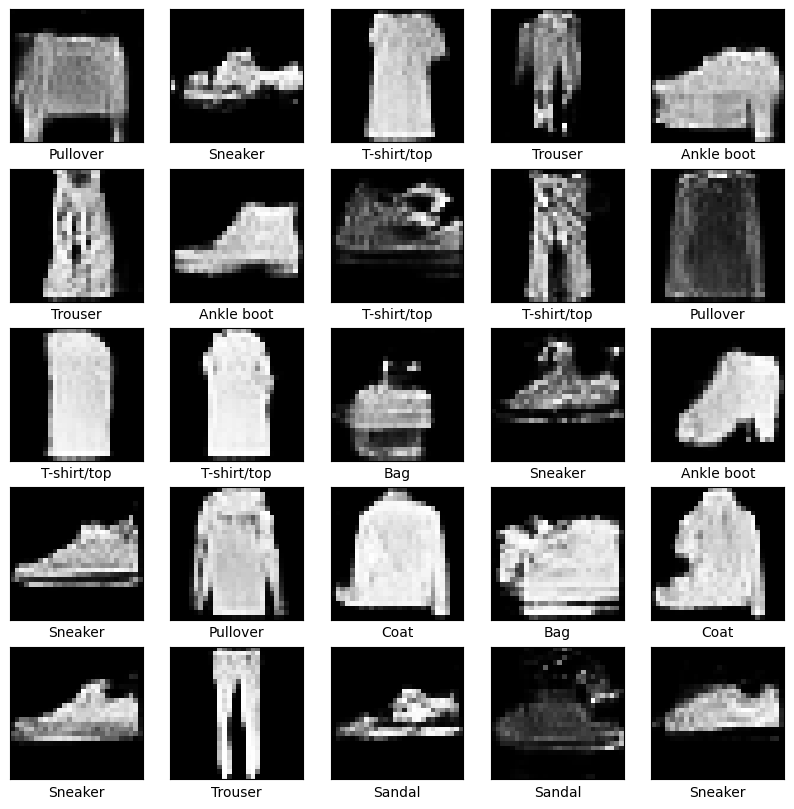

lab2_submission.zip ready for download.


In [5]:
# 1. Generate 100 synthetic images
print("Generating 100 final synthetic images...")
noise = tf.random.normal([100, noise_dim])
generated_images = generator(noise, training=False)

# Rescale to [0, 1] for saving and classification
generated_images_display = (generated_images + 1) / 2.0

# 2. Save individual images
for i in range(100):
    img = generated_images_display[i, :, :, 0]
    plt.imsave(f"final_generated_images/image_{i+1}.png", img.numpy(), cmap='gray')

# 3. Predict Labels using the pre-trained classifier
predictions = classifier.predict(generated_images, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

# 4. Display Distribution
unique, counts = np.unique(predicted_classes, return_counts=True)
print("\n--- Label Distribution of Generated Images ---")
for cls, count in zip(unique, counts):
    print(f"{class_names[cls]}: {count} images")

# 5. Display a few examples with predicted labels
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(generated_images_display[i, :, :, 0], cmap='gray')
    plt.xlabel(f"{class_names[predicted_classes[i]]}")
plt.show()

# Zip for download
import shutil
shutil.make_archive('lab2_submission', 'zip', 'final_generated_images')
print("lab2_submission.zip ready for download.")